In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Layer, Input, Flatten


2022-05-05 20:27:51.379429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 20:27:51.379462: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#filename = "ah78_long.csv"
filename = "ah78_month.csv"
#filename = "ah78_week.csv"

ts = pd.read_csv("simple_"+filename, index_col=0)
ts.index = pd.DatetimeIndex(ts.index.values, freq="5min")
ts.describe()


,y,a,b,c,h,yy,dy,B,A,C
count,7957.000000,8064.000000,8064.000000,8064.000000,3066.000000,8064.000000,8063.000000,8064.000000,8.064000e+03,8064.000000
mean,6.335716,5.135185,0.162712,0.606647,68.751931,6.340375,-0.000633,0.162680,5.135259e+00,0.606619
std,1.785341,16.261032,0.473934,4.299443,16.504785,1.786439,0.289426,0.060509,1.514972e+01,0.954469
min,2.164790,0.000000,0.000000,0.000000,41.000000,2.164790,-2.053780,0.043988,2.108928e-40,0.000000
25%,4.995670,0.000000,0.000000,0.000000,58.500000,4.995670,-0.166520,0.115482,6.825560e-10,0.005172
50%,6.050320,0.813500,0.063532,0.000000,66.000000,6.050320,0.000000,0.155945,1.250000e+00,0.173505
75%,7.493510,2.853500,0.119538,0.000000,73.500000,7.493510,0.111020,0.201714,3.695659e+00,0.793974
max,12.655700,192.893043,7.592103,60.000000,168.500000,12.655700,1.720730,0.520829,1.588831e+02,6.648057


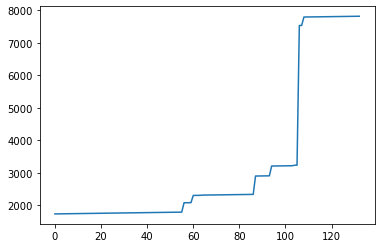

2904

In [3]:
fp_list = [i for i in range(len(ts.fp)) if ts.fp.iloc[i]]

plt.plot(fp_list)
plt.show()

j = np.random.choice(fp_list)
j


In [19]:
N = len(ts)
ts_test = ts.iloc[:N//5]
ts_train = ts.iloc[N//5:]
tau = 6

exogenous = ["a","b","c","A","B","C"]
no_exogen = len(exogenous)

lag = 12

N_train = len(ts_train)
X_train = np.vstack([ts_train["yy"].values[l:N_train-tau-lag+l] for l in range(1+lag)]).T
if no_exogen > 0:
    X_train = np.hstack([X_train,ts_train[exogenous].values[:N_train-tau-lag]])
#Y_train = ts_train["yy"].values[lag+tau:]
Y_train = np.vstack([ts_train["yy"].values[lag+t+1:N_train-tau+t+1] for t in range(tau)]).T

#X_test = ts_test[features].iloc[:-tau] 
#Y_test = ts_test["yy"].iloc[tau:]

N_test = len(ts_test)
X_test = np.vstack([ts_test["yy"].values[l:N_test-tau-lag+l] for l in range(1+lag)]).T
if no_exogen > 0:
    X_test = np.hstack([X_test,ts_test[exogenous].values[:N_test-tau-lag]])
#Y_test = ts_test["yy"].values[lag+tau:]
Y_test = np.vstack([ts_test["yy"].values[lag+t+1:N_test-tau+t+1] for t in range(tau)]).T

#plt.plot(X_train[:50,:1+lag])
#plt.plot(Y_train[:50], '--')
#plt.show()
#plt.plot(X_test[:50,:1+lag])
#plt.plot(Y_test[:50], '--')
#plt.show()

no_features = no_exogen + 1 + lag

N_train, X_train.shape, Y_train.shape, N_test, X_test.shape, Y_test.shape, no_features


(6452, (6434, 19), (6434, 6), 1612, (1594, 19), (1594, 6), 19)

In [20]:
def mdn_cost(mu_, sigma_, y_):
    #mu_ = Flatten()(mu)
    #sigma_ = Flatten()(sigma)
    #y_ = Flatten()(y)
    dist = tfp.distributions.Normal(loc=mu_, scale=sigma_)
    return tf.reduce_mean(-dist.log_prob(y_))


In [21]:
learning_rate = 0.0003

InputLayer = Input(shape=(no_features,))
#Layer_1 = Dense(12,activation="tanh")(InputLayer)
#Layer_2 = Dense(12,activation="tanh")(Layer_1)
Layer_1 = Dense(12,activation="relu")(InputLayer)
Layer_2 = Dense(12,activation="relu")(Layer_1)
mu = Dense(tau, activation="linear")(Layer_2)
sigma = Dense(tau, activation=lambda x: tf.nn.elu(x) + 1.001)(Layer_2)
y_real = Input(shape=(tau,))
lossF = mdn_cost(mu,sigma,y_real)
model = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 12)           240         ['input_9[0][0]']                
                                                                                                  
 dense_17 (Dense)               (None, 12)           156         ['dense_16[0][0]']               
                                                                                                  
 input_10 (InputLayer)          [(None, 6)]          0           []                               
                                                                                            

In [11]:
history_cache = model.fit([X_train, Y_train], #notice we are using an input to pass the real values due to the inner workings of keras
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))
mu_pred, sigma_pred = model.predict(list((X_test,Y_test))) # the model expects a list of arrays as it has 2 inputs

Epoch 1/100
129/129 [==============================] - 1s 1ms/step - loss: 2466393.0000 - dense_14_mse: 0.0000e+00 - dense_15_mse: 0.0000e+00
Epoch 2/100
129/129 [==============================] - 0s 2ms/step - loss: 857817.3125 - dense_14_mse: 0.0000e+00 - dense_15_mse: 0.0000e+00
Epoch 3/100
129/129 [==============================] - 0s 2ms/step - loss: 284002.7500 - dense_14_mse: 0.0000e+00 - dense_15_mse: 0.0000e+00
Epoch 4/100
129/129 [==============================] - 0s 2ms/step - loss: 14616.0488 - dense_14_mse: 0.0000e+00 - dense_15_mse: 0.0000e+00
Epoch 5/100
129/129 [==============================] - 0s 2ms/step - loss: 1245.9644 - dense_14_mse: 0.0000e+00 - dense_15_mse: 0.0000e+00
Epoch 6/100
129/129 [==============================] - 0s 2ms/step - loss: 955.5464 - dense_14_mse: 0.0000e+00 - dense_15_mse: 0.0000e+00
Epoch 7/100
129/129 [==============================] - 0s 2ms/step - loss: 866.0553 - dense_14_mse: 0.0000e+00 - dense_15_mse: 0.0000e+00
Epoch 8/100
129/129 [

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 12)           168         ['input_7[0][0]']                
                                                                                                  
 dense_13 (Dense)               (None, 12)           156         ['dense_12[0][0]']               
                                                                                                  
 input_8 (InputLayer)           [(None, 3)]          0           []                               
                                                                                            

In [13]:
mu_pred.shape, sigma_pred.shape

((1603, 3), (1603, 3))

In [15]:
j = 500

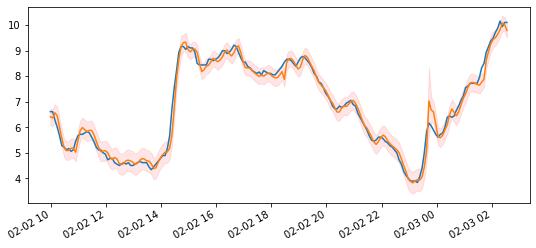

In [17]:
t = 1
time_index = ts_test.index[lag+t:]
predicted_mean = mu_pred[:,0]
predicted_sigma = sigma_pred[:,0]

time_index.shape

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)

plt.show()

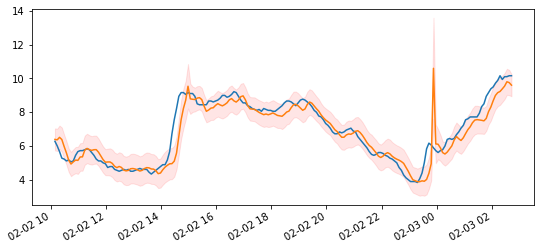

In [18]:
t = tau
time_index = ts_test.index[lag+t:]
predicted_mean = mu_pred[:,tau-1]
predicted_sigma = sigma_pred[:,tau-1]

time_index.shape

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)

plt.show()